In [1]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz

--2023-12-15 17:56:53--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2023-12-15 17:56:53--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2023-12-15 17:56:53--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
#print(test_images.shape)

(2811, 244, 244, 3) (2811, 42, 2)


Data pre-process

In [3]:
#grayscale the image first
gray_images=np.zeros(images.shape[:-1])
for i in range(images.shape[0]):
  gray_images[i]=np.uint8(np.mean(images[i],axis=-1))

#smaller the image
sma_img=np.zeros((2811,61,61))
for i in range(2811):
  sma_img[i] = cv2.resize(gray_images[i], (61 , 61), interpolation=cv2.INTER_AREA)

#smaller the points
sma_pts=np.zeros((2811,42,2))
for i in range(2811):
  sma_pts[i][:,0]=pts[i][:,0]//4
  sma_pts[i][:,1]=pts[i][:,1]//4

#flatten the pts into 1d
fla_pts=np.zeros((2811,84))
for i in range(sma_pts.shape[0]):
  fla_pts[i]=sma_pts[i].flatten()

#split the training set and validation set
valid_images=sma_img[-500:]
valid_pts=fla_pts[-500:]
train_images=sma_img[:-500]
train_pts=fla_pts[:-500]
print(len(train_images))

2311


2485


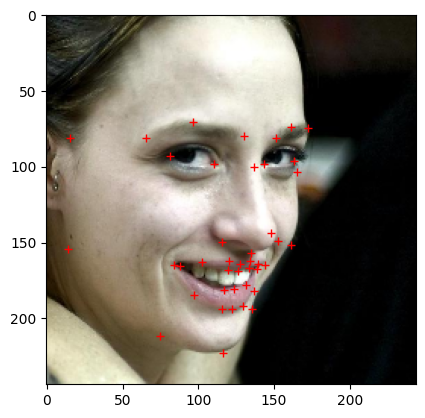

In [4]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(1):
    idx = np.random.randint(0, images.shape[0])
    print(idx)
    visualise_pts(images[idx, ], pts[idx, ])

Try to use CNN

In [5]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
# Include numpy for basic stuff
import numpy as np
# matplotlib allows us to visualise our data.
import matplotlib.pyplot as plt
# Import a library for displaying models
from IPython.display import Image

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_pts))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_pts))
val_dataset = val_dataset.batch(64)

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from math import sin, cos, pi

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential

In [8]:
# residual network 50
model = Sequential()
pretrained_model = ResNet50(input_shape=(61,61,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True


model.add(Conv2D(3, (1,1), padding='same', input_shape=(61,61,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(84))
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 61, 61, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 84)                17

In [9]:
%%time

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(train_images, train_pts, epochs=30, batch_size=64, validation_data=val_dataset, callbacks=[earlyStopping, rlp])

Epoch 1/30
37/37 [==============================] - 47s 183ms/step - loss: 256.1197 - accuracy: 0.2912 - val_loss: 830.5110 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 2/30
37/37 [==============================] - 3s 79ms/step - loss: 7.5700 - accuracy: 0.7971 - val_loss: 60.3000 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 3/30
37/37 [==============================] - 3s 80ms/step - loss: 6.2451 - accuracy: 0.7975 - val_loss: 68.6728 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 4/30
37/37 [==============================] - 4s 106ms/step - loss: 4.6682 - accuracy: 0.7966 - val_loss: 52.0453 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 5/30
37/37 [==============================] - 3s 82ms/step - loss: 3.5296 - accuracy: 0.8035 - val_loss: 24.7077 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 6/30
37/37 [==============================] - 3s 80ms/step - loss: 2.9577 - accuracy: 0.8174 - val_loss: 29.8703 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 7/30
37/37 [==============================] - 3s 80ms/step

Text(0.5, 0.98, 'Model Metrics')

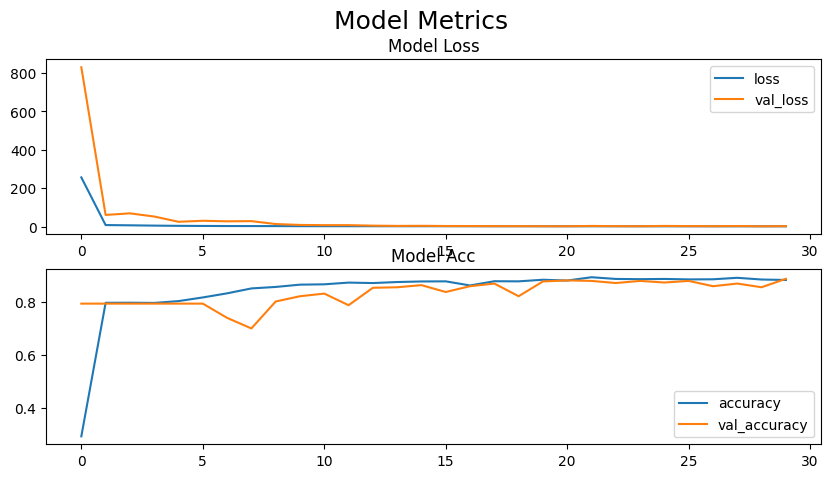

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

In [11]:
#try to find the error

def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [12]:
valid_preds = model.predict(valid_images)

dis=euclid_dist(valid_preds,valid_pts)


16/16 [==============================] - 3s 59ms/step


In [13]:
np.average(dis)

1.744164761872488

In [14]:
#before the prediction, need to pre process the testing set as well
#grayscale the image first
gray_img_test=np.zeros(test_images.shape[:-1])
for i in range(test_images.shape[0]):
  gray_img_test[i]=np.uint8(np.mean(test_images[i],axis=-1))

#smaller the image
sma_img_test=np.zeros((554,61,61))
for i in range(554):
  sma_img_test[i] = cv2.resize(gray_img_test[i], (61 , 61), interpolation=cv2.INTER_AREA)

In [15]:
#prediction
test_preds = model.predict(sma_img_test)

18/18 [==============================] - 1s 74ms/step


In [16]:
#need to unflatten the pts
unfla_pts=np.zeros((554,42,2))
for i in range(554):
    unfla_pts[i]=test_preds[i].reshape(42,2)

#make the points back to original size
test_pts=np.zeros((554,42,2))
for i in range(554):
    test_pts[i][:,0]=unfla_pts[i][:,0]*4
    test_pts[i][:,1]=unfla_pts[i][:,1]*4


369


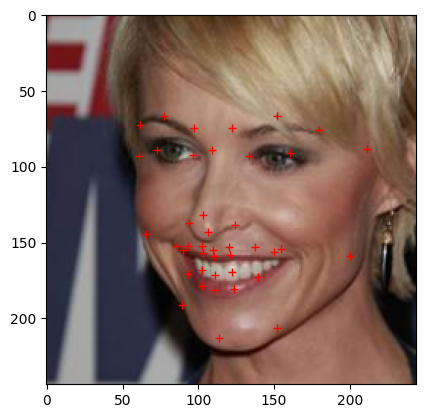

432


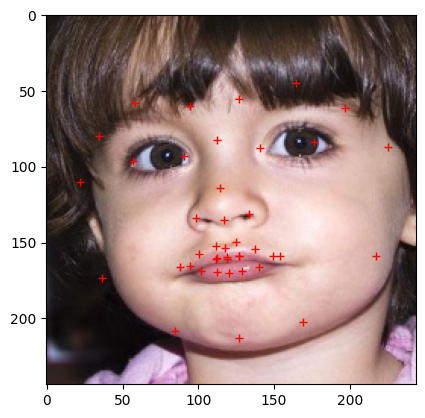

324


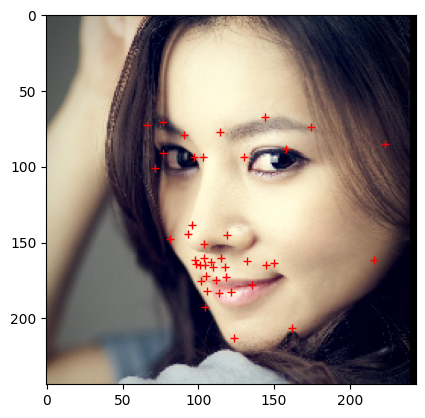

In [17]:
#visualization
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    print(idx)
    visualise_pts(test_images[idx, ], test_pts[idx, ])

In [ ]:
#download the result
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

save_as_csv(test_pts,location='.')

Try to augment the image, if the accuracy changed

Rotate the imagee

73/73 [==============================] - 1s 14ms/step
1794


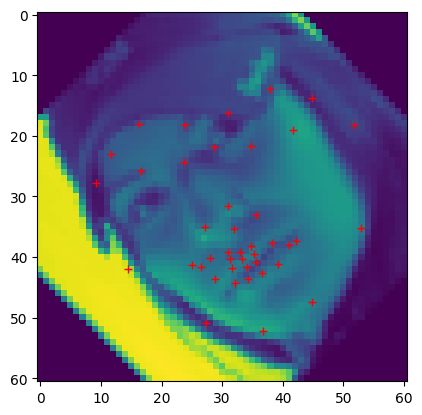

2280


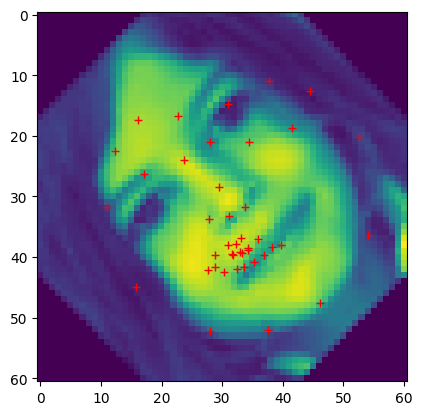

1956


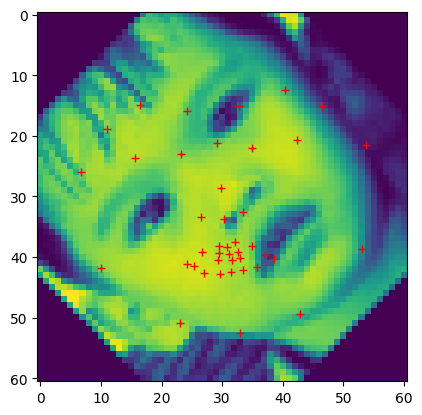

In [18]:
import imutils

train_img_rotate=np.zeros(train_images.shape)
for i in range(2311):
  train_img_rotate[i]=imutils.rotate(train_images[i], angle=45)

#prediction
test1 = model.predict(train_img_rotate)

#need to unflatten the pts
unfla_pts=np.zeros((2311,42,2))
for i in range(2311):
    unfla_pts[i]=test1[i].reshape(42,2)


#visualization
for i in range(3):
    idx = np.random.randint(0, train_img_rotate.shape[0])
    print(idx)
    visualise_pts(train_img_rotate[idx, ], unfla_pts[idx, ])

Change the color of lips and eyes

In [19]:
def lips_color(idx):
    #initialization
    img=test_images[idx]
    lipsPoints = test_pts[idx][-20:]  #last 20 points are for lips

    #make a mask with the shape of image
    mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.float32)
    #draw ConvexPoly
    cv2.fillConvexPoly(mask, np.int32(lipsPoints), (30,30,30))
    mask = 255*np.uint8(mask)
    #apply closing operation to lips, it can make lips more complete
    kernel = np.ones((15,15),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #apply blur, make edge of lips look natural
    mask = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)
    #Calculate inverse mask
    inverseMask = cv2.bitwise_not(mask)
    #Convert masks to float to perform blending
    mask = mask.astype(float)/255
    inverseMask = inverseMask.astype(float)/255
    #apply color to the lips
    lips = cv2.applyColorMap(img, cv2.COLORMAP_DEEPGREEN)
    #Convert lips and face to 0-1 range
    lips = lips.astype(float)/255
    Face = img.astype(float)/255
    #Multiply lips and face by the masks
    justLips = cv2.multiply(mask, lips)
    justFace = cv2.multiply(inverseMask, Face)
    #add them together
    result = justFace + justLips
    return result

258


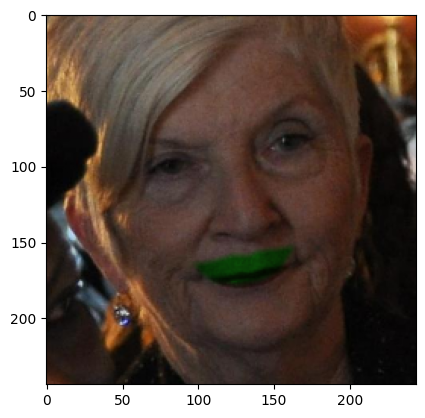

66


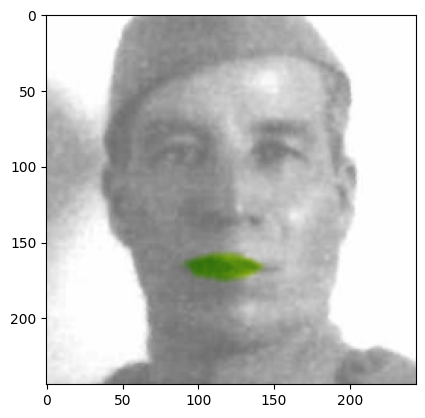

278


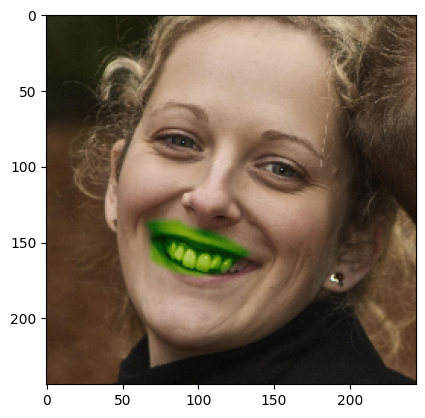

In [20]:
# show lips result randomly
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    print(idx)
    plt.imshow(lips_color(idx))
    plt.show()
